### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take, delete
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text
    

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [0]:
data = read_text("/content/drive/My Drive/ULTIMA PRACTICA ANALISIS/spa.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [0]:
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [6]:
deu_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face.', 'Su cara mostraba fatiga.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name.',
        'Pocos estudiantes conocían su nombre.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire.', 'Rellena el cuestionario.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [0]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [8]:
deu_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face', 'Su cara mostraba fatiga',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name',
        'Pocos estudiantes conocían su nombre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire', 'Rellena el cuestionario',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

In [0]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [0]:
deu_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['fatigue showed on her face', 'su cara mostraba fatiga',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['few students knew his name',
        'pocos estudiantes conocían su nombre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['fill out the questionnaire', 'rellena el cuestionario',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [0]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [0]:
#Escojo las palabras que tengan menos de 4 de longitud
spa = []
engnew= []

for position, sentence in enumerate(deu_eng[:,0]):
  if(len(sentence.split()) <=6 and len(engnew) < 48099):
    engnew.append(sentence)
   

for position, sentence in enumerate(deu_eng[:,1]):
  if(len(sentence.split()) <= 6 ):
    spa.append(sentence)

In [0]:

# empty lists
english_len = []
spanish_len = []

# populate the lists with sentence lengths
for i in engnew:
    english_len.append(len(i.split()))

for i in spa:
    spanish_len.append(len(i.split()))

In [64]:

print(len(english_len))
print(len(spanish_len))

48099
48099


In [12]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.deu))
#mio
length_df_new = pd.DataFrame({'spa':spanish_len, 'engnew':english_len})
print(length_df_new)
print(max(length_df_new.spa))
print(max(length_df_new.engnew))

       eng  deu
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    4    4
49996    6    6
49997    5    4
49998    5    5
49999    4    3

[50000 rows x 2 columns]
8
12
       spa  engnew
0        1       1
1        1       1
2        1       1
3        1       1
4        1       1
...    ...     ...
48094    4       4
48095    6       5
48096    4       6
48097    5       6
48098    3       6

[48099 rows x 2 columns]
6
6


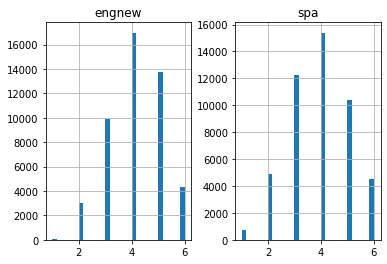

In [66]:
#comprobamos que tiene longitud 6
length_df_new.hist(bins = 30)
plt.show()

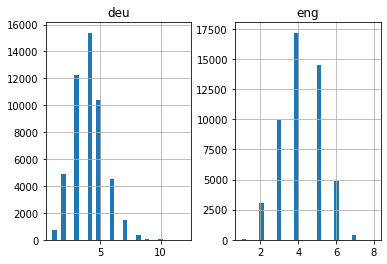

In [67]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [14]:
# prepare english tokenizer
engnew_tokenizer = tokenization(engnew)
engnew_vocab_size = len(engnew_tokenizer.word_index) + 1

engnew_length = 6
print('English Vocabulary Size: %d' % engnew_vocab_size)

English Vocabulary Size: 6793


In [15]:
# prepare Deutch tokenizer
spa_tokenizer = tokenization(spa)
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 6
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 13923


In [16]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 112), ('vete', 30), ('vaya', 31), ('váyase', 7), ('hola', 12), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 1), ('¿quién', 370), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 2), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 10), ('continúa', 14), ('continúe', 6), ('me', 2866), ('oculté', 1), ('escondí', 3), ('ocultaba', 1), ('escondía', 1), ('corrí', 10), ('corría', 4), ('lo', 1928), ('intento', 8), ('¡he', 2), ('ganado', 16), ('¡oh', 3), ('no', 5539), ('tomátelo', 2), ('con', 769), ('soda', 3), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 5), ('¡al', 2), ('ataque', 5), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 22), ('ahora', 487), ('mismo', 125), ('id', 7), ('vayan', 10), ('ya', 325), ('¡lo', 10), ('tengo', 848), ('¿lo', 63), ('pillas', 1), ('¿entendi

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

<bound method Tokenizer.texts_to_sequences of <keras_preprocessing.text.Tokenizer object at 0x000001D5AD17AA08>>


### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [19]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(engnew_tokenizer, engnew_length, train[:, 0])

[[   1    2  991  209    4   36]
 [  12   14  780    6 1508 2845]
 [  29  471   13   10   94  224]
 ...
 [   9 3304    8  658    0    0]
 [4396   13   42  275   10 1452]
 [  76  389  258    0    0    0]]
40000
[[   3  490   68   40    0    0]
 [   9  316   44 1026 1029    0]
 [   1   19   69   23    2   52]
 ...
 [   2  316   13  690    0    0]
 [1190  150  734  150    2   26]
 [   1   52    7  216   76    0]]
40000


In [75]:
print(trainX.shape)
print(trainY.shape)

(40000, 6)
(40000, 6)


In [20]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(engnew_tokenizer, engnew_length, test[:, 0])

[[1045   80 1202   26    0    0]
 [  22   83   27    0    0    0]
 [  70   20  795    0    0    0]
 ...
 [1207  161   24 3848    0    0]
 [  37  248    6  997    0    0]
 [   3  273  145  130    0    0]]
10000
[[  82   51   34   11  330    0]
 [   1  110   37    0    0    0]
 [  72  520    2    0    0    0]
 ...
 [  12    2   27 2315    0    0]
 [   2   19  659  941    0    0]
 [   9    4  217    7   50    0]]
10000


In [21]:
print(testX.shape)
print(testY.shape)

(10000, 6)
(10000, 6)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

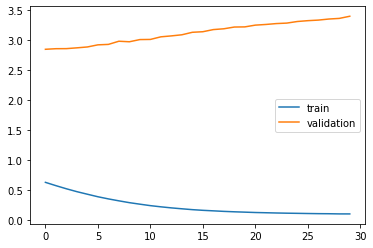

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:

# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

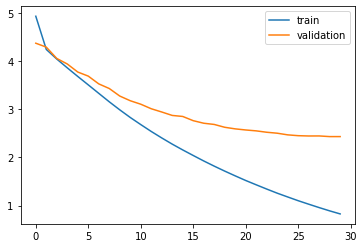

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model


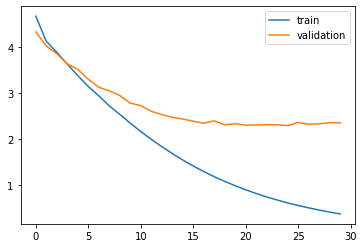

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [23]:
print(spa_vocab_size)
print(engnew_vocab_size)
print(spa_length)
print(engnew_length)

13923
6793
6
6


In [0]:
model = build_model(spa_vocab_size, engnew_vocab_size, spa_length, engnew_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [23]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 155s 5ms/step - loss: 4.6656 - val_loss: 4.3262

Epoch 00001: val_loss improved from inf to 4.32622, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 154s 5ms/step - loss: 4.1199 - val_loss: 4.0206

Epoch 00002: val_loss improved from 4.32622 to 4.02061, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 155s 5ms/step - loss: 3.8812 - val_loss: 3.8500

Epoch 00003: val_loss improved from 4.02061 to 3.85004, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 155s 5ms/step - loss: 3.6255 - val_loss: 3.6288

Epoch 00004: val_loss improved from 3.85004 to 3.62883, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 154s 5ms/step - loss: 3.3740 - val_loss: 3.5108

Epoch 00005: val_loss improved from 3.62883 to 3.51083, 

Let's compare the training loss and the validation loss.

### Make Predictions

Let's load the saved model to make predictions.

In [29]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [31]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

NameError: ignored

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [0]:
pred_df.head(15)

,actual,predicted
0,so how did this happen,good me very
1,i eat here,i can go
2,who helped you,didnt canadian you
3,smoke appeared,he lazy all
4,they went to new zealand,your read to money
5,can you explain it to me,you strong do to do
6,four times five is twenty,sky sugar iphone is surgery
7,i just wanted to see you,will children to an you
8,im a little crazy,this a friend stand
9,im sorry for what i did,shoes good in i want


In [0]:
pred_df.tail(15)

,actual,predicted
9985,you really are nuts,this bicycle you
9986,they kept running,be travel all
9987,all of these are mine,come youre keep im bought
9988,youve come too early,you once one hear
9989,nobody can stop tom,when not shes tom
9990,i dont mind waiting,i was with
9991,happy thanksgiving,this a youre very
9992,i loved her,i forget were
9993,did you come here alone,that you need go please
9994,were surrounded,on against


In [0]:
pred_df.tail(15)

,actual,predicted
9985,you really are nuts,this bicycle you
9986,they kept running,be travel all
9987,all of these are mine,come youre keep im bought
9988,youve come too early,you once one hear
9989,nobody can stop tom,when not shes tom
9990,i dont mind waiting,i was with
9991,happy thanksgiving,this a youre very
9992,i loved her,i forget were
9993,did you come here alone,that you need go please
9994,were surrounded,on against


In [0]:
pred_df.sample(15)

,actual,predicted
1154,are you thinking about tom,im you shortly home tom
9636,where will you be going,too no and know
858,he is unmarried,am is
4475,is there school tomorrow,is it all
6489,does it look cloudy today,it show to started
157,tom finished his homework,tom is him bald
9902,im still busy,this tell house
3050,do you accept credit cards,that who youre miracle angel
7939,keep paddling,been
3013,toms family is eccentric,think is
